# Clustering
* use the collected data (text and wikidata descriptions) to automatically cluster persons
    * first, using 2 clusters
    * second, using 6 clusters

* compare the results obtained when using
    * three ways of representing text (tokens, token
    * frequency and tf-idf) and 2 vs. 6 clusters.

In [11]:
import csv
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn import metrics 
import numpy as np
from itertools import chain

# Visualisation
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram

In [14]:
with open('data/data.csv', 'r') as f:
    df = pd.read_csv(f, index_col=0)
df.head()

,person,description,p_description,content,p_content,label_2,label_6
0,Kichka_Bodurova,Bulgarian pop-folk musician,"['bulgarian', 'popfolk', 'musician']","Big Brother: All-Stars, also known as Big Brot...","[['big', 'brother', 'allstars', 'also', 'known...",A,singer
1,Taras_Topolya,Ukrainian singer,"['ukrainian', 'singer']",EdCamp Ukraine (Ukrainian: ЕдКемп Україна) is ...,"[['edcamp', 'ukraine', 'ukrainian', 'едкемп', ...",A,singer
2,Louis_Graveure,"English actor and baritone singer known as ""Th...","['english', 'actor', 'baritone', 'singer', 'kn...",The Accusing Song (German: Ein Lied klagt an) ...,"[['accusing', 'song', 'german', 'ein', 'lied',...",A,singer
3,Philippe_Robrecht,Belgian guitarist and singer,"['belgian', 'guitarist', 'singer']",Jacques Romain Georges Brel (French: [ʒɑk ʁɔmɛ...,"[['jacques', 'romain', 'georges', 'brel', 'fre...",A,singer
4,Moira_Lambert,British singer,"['british', 'singer']",Mary Rose Byrne (born 24 July 1979) is an Aust...,"[['mary', 'rose', 'byrne', 'born', '24', 'july...",A,singer


In [4]:
eval(df.p_description[0])

['bulgarian', 'popfolk', 'musician']

In [15]:
# labels
y_2 = df.label_2
y_6 = df.label_6


#data
eva = list(map(eval, df.p_description))
X_d = list(map(lambda x: ' '.join(x), eva))

eva = list(map(eval, df.p_content))
flattened_eva = list(map(lambda x: list(chain(*x)), eva))
X_c = list(map(lambda x: ' '.join(x), flattened_eva))

In [33]:
# methods
count_v = CountVectorizer()
one_hot = OneHotEncoder(categories=[t for description in df.p_description for t in description])
tfidf = TfidfVectorizer(max_features = 20,
                                use_idf = True,
                                stop_words = 'english',
                                tokenizer = word_tokenize)

methods = {'tfidf':tfidf, 'count_v':count_v} #'one_hot':one_hot

# number of clusters
cluster_numbers =  [2,6]
labels_n_clusters = [(2, y_2), (6, y_6)]

## Part 1
Define a function to train a clustering algorithm on some data using N clusters and some input representation method M (tokens, token frequency and tf-idf).
Data, M and N should be parameters of that function.

In [19]:
def train_cluster(data, n_clusters, method = tfidf):
    vectorised_input = method.fit_transform(data)

    km = KMeans(n_clusters)
    km.fit(vectorised_input)
    return km, vectorised_input

In [20]:
clusters, vectorised_input = train_cluster(data=X_d, n_clusters=2, method = tfidf)

## Part 2
Define a function to compute both intrinsic (Silhouette coefficient) and extrinsic (homogeneity, completeness, v-measure, adjusted Rand index) evaluation scores for clustering results.

In [23]:
def compute_scores(labels, clustering, vectorised_input):
    # When a ground truth is available 

    homo = (metrics.homogeneity_score(labels, clustering)) 
    comp = (metrics.completeness_score(labels, clustering)) 
    v_m = (metrics.v_measure_score(labels, clustering)) 
    ari = (metrics.adjusted_rand_score(labels, clustering)) 

    # When no ground truth is available 

    silh = (metrics.silhouette_score(vectorised_input, clustering, sample_size=1000))

    return homo, comp, v_m, ari, silh
    

In [24]:
compute_scores(labels=y_2, clustering=clusters.labels_, vectorised_input=vectorised_input)
#	2	tfidf	0.148189	0.261583	0.189197	0.068706	0.040668

(0.13216336409604673,
 0.2167179884207683,
 0.1641943784223112,
 0.07452366180212745,
 0.14237244954362463)

In [39]:
#Create dataframe with scores
data = pd.DataFrame(columns=['n_clusters','method',*'homogeneity, completeness, v_measure, adjusted_rand_index, silhouette_coef'.split(', ')])

for n_clusters, labels in labels_n_clusters:
    for name,method in methods.items():
        print(name)

        clusters, vectorised_input = train_cluster(data=X_d,                                           
                                                    n_clusters=n_clusters,
                                                    method=method)
        scores = compute_scores(labels=labels,
                                clustering=clusters.labels_,
                                vectorised_input=vectorised_input)


        new_row = []
        new_row.append(n_clusters)
        new_row.append(name)
        new_row.extend(scores)
        
        data.loc[len(data.n_clusters)] = new_row
        

tfidf
count_v
tfidf
count_v


In [40]:
data.head()

,n_clusters,method,homogeneity,completeness,v_measure,adjusted_rand_index,silhouette_coef
0,2,tfidf,0.132163,0.216718,0.164194,0.074524,0.142372
1,2,count_v,0.026319,0.031770,0.028788,0.023568,0.048745
2,6,tfidf,0.642348,0.686023,0.663467,0.482390,0.317151
3,6,count_v,0.623665,0.680586,0.650883,0.436147,0.110154


## Part 3
Define a function to visualise those metrics values for each of the three input representations (tokens, token frequency and tf-id) and for 2 vs. 6 clusters (so your visualisation should display 5 scores for each of the 6 clustering results)

In [45]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [60]:
sns.set_theme(style="whitegrid")

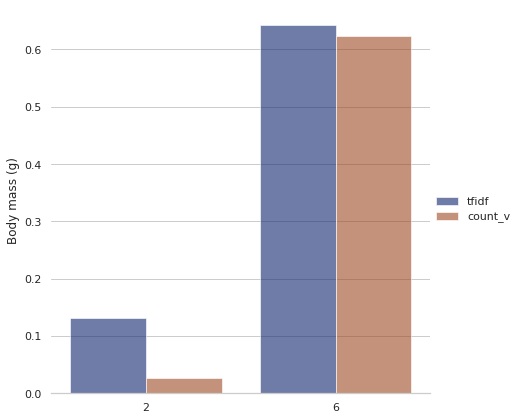

In [61]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=data, kind='bar',
    x='n_clusters', y='homogeneity', hue='method',
    palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")

In [36]:
l = ['A','Z']
{i : name for i,name in enumerate(l)}


{0: 'A', 1: 'Z'}

In [ ]:
def visualise_metrics()):
    


In [37]:
def visualise_clusters(vectorised_input, label_names, ):

    dist = 1 - cosine_similarity(vectorised_input)

    # Use multidimensional scaling to convert the dist matrix into a 2-dimensional array 

    MDS()

    # n_components=2 to plot results in a two-dimensional plane
    # "precomputed" because the  distance matrix dist is already computed
    # `random_state` set to 0 so that the plot is reproducible.
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)

    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]



    #set up colors per clusters using a dict
    # #1b9e77 (green) #d95f02 (orange) #7570b3 (purple) #e7298a (pink)
    colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#000000'}

    
    #set up cluster names using a dict
    cluster_names = {i = name for i,name in enumerate(label_names)}
    cluster_colors = {colors[i] for i in cluster_names.keys()}

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=cluster_names))

    #group by cluster
    groups = df.groupby('label')

    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=cluster_names[name], 
                color=cluster_colors[name], 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelleft=False)
        
        ax.legend(numpoints=1)  #show legend with only 1 point
            
            
            plt.show() #show the plot
        
        linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

        fig, ax = plt.subplots(figsize=(15, 20)) # set size
        ax = dendrogram(linkage_matrix, orientation="right");
        plt.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        plt.tight_layout() #show plot with tight layout

        #uncomment below to save figure
        plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

SyntaxError: invalid syntax (<ipython-input-37-2db8eb2851ad>, line 26)

In [ ]:
for method,scores in data:
    visualise_metrics(scores)